In [1]:
import keras
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
import numpy as np
import pandas as pd
from collections import defaultdict
import re,string,unicodedata


import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, merge, Dropout
from keras.models import Model
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import PorterStemmer,WordNetLemmatizer
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2865660859841525414
]


In [2]:
def clean_str(string):
    """
    Cleaning of dataset
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [3]:
true = pd.read_csv(r'H:\FakeNews\Authentic-48K.csv', na_values=['#NAME?'])
false = pd.read_csv(r'H:\FakeNews\Fake-1K.csv', na_values=['#NAME?'])

In [4]:
data_train = pd.concat([false, true], ignore_index=True, sort=False)
data_train

,articleID,domain,date,category,headline,content,label
0,1,channeldhaka.news,2019-03-14T13:34:14+00:00,International,মুরগির হামলায় শেয়াল নিহত,"বাংলায় একটা প্রবাদ আছে, শেয়ালের কাছে মুরগী বর্...",0
1,2,earki.com,"সেম্বর ১৭, ২০১৮",Miscellaneous,বিটিভিতে যেবার আমি ইন্টারভিউ দিতে গেলাম,"BTV থেকে লোকজন আসছে, ইন্টারভিউ নিবে।চারজনের টি...",0
2,3,earki.com,"২০:৩৯, জানুয়ারি ১৪, ২০১৯",Miscellaneous,বিদেশ থেকে উন্নতমানের বিরোধীদল আমদানি করার পরা...,অদ্ভুত বিরোধীদলহীনতায় ভুগছে সরকার। এ এক অন্যরক...,0
3,4,channeldhaka.news,2018-06-30T15:56:47+00:00,Sports,অবসর নেয়ার ঘোষণা দিলেন মেসি !,রাশিয়া বিশ্বকাপ নকআউট পর্বে ফ্রান্সের সাথে ৪-৩...,0
4,5,motikontho.wordpress.com,2013-03-05T21:55:45+00:00,Miscellaneous,"মাদারফাকার নহে, ব্রাদারফাকার: সাকা | দৈনিক মতি...","নিজস্ব মতিবেদক‘মাদারফাকার নহে, আমি ব্রাদারফাকা...",0
...,...,...,...,...,...,...,...
49972,61776,banglanews24.com,2018-10-11 16:39:23,Sports,"এনসিএলে তিতলির প্রভাব, সব ম্যাচ ড্র",প্রথমে বাংলাদেশের কাছ দিয়ে যাওয়ার কথা থাকলেও ঘ...,1
49973,61777,banglanews24.com,2018-10-11 16:39:27,International,"কর্ম-বসবাসে সেরা সিঙ্গাপুর, আয়ে সুইজারল্যান্ড",উন্নত জীবনযাপনের জন্য অনেকেই বিদেশে পাড়ি দেন। ...,1
49974,61778,banglanews24.com,2018-10-11 16:39:30,Politics,জয়পুরহাটে জামায়াতের ১৯ নেতাকর্মী আটক,জয়পুরহাট: সরকার বিরোধী গোপন বৈঠকের সময় জয়পুরহা...,1
49975,61779,banglanews24.com,2018-10-11 16:39:32,National,ভ্যানগার্ড পোশাক কারখানাকে জরিমানা,চট্টগ্রাম: পরিবেশ দূষণের দায়ে নগরের আগ্রাবাদ এ...,1


In [5]:
del data_train['date']
del data_train['articleID']
del data_train['domain']
del data_train['category']

In [6]:
data_train

,headline,content,label
0,মুরগির হামলায় শেয়াল নিহত,"বাংলায় একটা প্রবাদ আছে, শেয়ালের কাছে মুরগী বর্...",0
1,বিটিভিতে যেবার আমি ইন্টারভিউ দিতে গেলাম,"BTV থেকে লোকজন আসছে, ইন্টারভিউ নিবে।চারজনের টি...",0
2,বিদেশ থেকে উন্নতমানের বিরোধীদল আমদানি করার পরা...,অদ্ভুত বিরোধীদলহীনতায় ভুগছে সরকার। এ এক অন্যরক...,0
3,অবসর নেয়ার ঘোষণা দিলেন মেসি !,রাশিয়া বিশ্বকাপ নকআউট পর্বে ফ্রান্সের সাথে ৪-৩...,0
4,"মাদারফাকার নহে, ব্রাদারফাকার: সাকা | দৈনিক মতি...","নিজস্ব মতিবেদক‘মাদারফাকার নহে, আমি ব্রাদারফাকা...",0
...,...,...,...
49972,"এনসিএলে তিতলির প্রভাব, সব ম্যাচ ড্র",প্রথমে বাংলাদেশের কাছ দিয়ে যাওয়ার কথা থাকলেও ঘ...,1
49973,"কর্ম-বসবাসে সেরা সিঙ্গাপুর, আয়ে সুইজারল্যান্ড",উন্নত জীবনযাপনের জন্য অনেকেই বিদেশে পাড়ি দেন। ...,1
49974,জয়পুরহাটে জামায়াতের ১৯ নেতাকর্মী আটক,জয়পুরহাট: সরকার বিরোধী গোপন বৈঠকের সময় জয়পুরহা...,1
49975,ভ্যানগার্ড পোশাক কারখানাকে জরিমানা,চট্টগ্রাম: পরিবেশ দূষণের দায়ে নগরের আগ্রাবাদ এ...,1


In [7]:
nltk.download('stopwords')
stop = set(stopwords.words('bangla'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\u\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [8]:
stemmer = PorterStemmer()
def stem_text(content):
    final_text = []
    for i in content.split():
        if i.strip().lower() not in stop:
            word = stemmer.stem(i.strip())
            final_text.append(word)
    return " ".join(final_text)  

In [9]:
data_train.content = data_train.content.apply(stem_text)

In [10]:
stemmer = PorterStemmer()
def stem_text(headline):
    final_text = []
    for i in headline.split():
        if i.strip().lower() not in stop:
            word = stemmer.stem(i.strip())
            final_text.append(word)
    return " ".join(final_text)  

In [11]:
data_train.content = data_train.headline.apply(stem_text)

In [12]:
# Input Data preprocessing
data_train = data_train
print(data_train.columns)
print('What the raw input data looks like:')
print(data_train[0:5])
texts = []
labels = []

for i in range(data_train.content.shape[0]):
    text1 = data_train.headline[i]
    text2 = data_train.content[i]
    text = str(text1) +""+ str(text2)
    texts.append(text)
    labels.append(data_train.label[i])
    
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Index(['headline', 'content', 'label'], dtype='object')
What the raw input data looks like:
                                            headline  \
0                           মুরগির হামলায় শেয়াল নিহত   
1            বিটিভিতে যেবার আমি ইন্টারভিউ দিতে গেলাম   
2  বিদেশ থেকে উন্নতমানের বিরোধীদল আমদানি করার পরা...   
3                      অবসর নেয়ার ঘোষণা দিলেন মেসি !   
4  মাদারফাকার নহে, ব্রাদারফাকার: সাকা | দৈনিক মতি...   

                                             content  label  
0                           মুরগির হামলায় শেয়াল নিহত      0  
1                     বিটিভিতে যেবার ইন্টারভিউ গেলাম      0  
2  বিদেশ উন্নতমানের বিরোধীদল আমদানি পরামর্শ অনলাই...      0  
3                              অবসর নেয়ার ঘোষণা মেসি      0  
4   মাদারফাকার নহে, ব্রাদারফাকার: সাকা দৈনিক মতিকণ্ঠ      0  
Found 72355 unique tokens.


In [13]:
# Pad input sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels),num_classes = 2)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (49977, 1000)
Shape of label tensor: (49977, 2)


In [14]:
from sklearn.model_selection import train_test_split

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train, x_test, y_train, y_test = train_test_split( data, labels, test_size=0.20, random_state=42)
x_test, x_val, y_test, y_val = train_test_split( x_test, y_test, test_size=0.50, random_state=42)
print('Size of train, validation, test:', len(y_train), len(y_val), len(y_test))

print('real & fake news in train,valt,test:')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Size of train, validation, test: 39981 4998 4998
real & fake news in train,valt,test:
[ 1011. 38970.]
[ 157. 4841.]
[ 131. 4867.]


In [15]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization

In [16]:
import numpy as np
from matplotlib import pyplot as plt
from keras.layers import Dense, Embedding, LSTM, GRU

%matplotlib inline

In [17]:
#Using Pre-trained word embeddings
GLOVE_DIR = "H:\FakeNews" 
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'bn_glove.39M.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    #print(values[1:])
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)

Total 178153 word vectors in Glove.


In [18]:
embedding_vecor_length = 32
modelh = Sequential()
modelh.add(embedding_layer)
modelh.add(Dropout(0.2))
modelh.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
modelh.add(MaxPooling1D(pool_size=2))
modelh.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
modelh.add(MaxPooling1D(pool_size=2))
modelh.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
###
modelh.add(BatchNormalization())
###
#modelh.add(Dense(64, activation='relu'))
modelh.add(Dense(2, activation='softmax'))
modelh.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modelh.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         7235600   
_________________________________________________________________
dropout (Dropout)            (None, 1000, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1000, 32)          16032     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 500, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 64)           6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 64)           0         
_________________________________________________________________
gru (GRU)                    (None, 100)               4

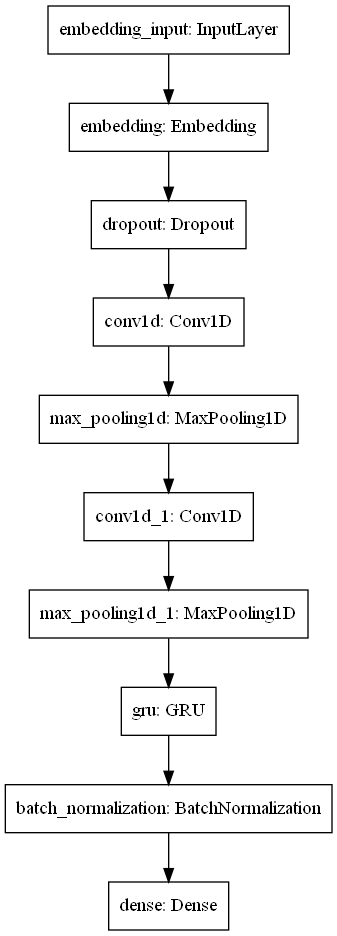

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(modelh, to_file='modelh.png')

In [20]:
history = modelh.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=128)
modelh.save('hybrid.h5')

Epoch 1/10
313/313 [==============================] - 379s 1s/step - loss: 0.1963 - accuracy: 0.9494 - val_loss: 0.0743 - val_accuracy: 0.9810
Epoch 2/10
313/313 [==============================] - 355s 1s/step - loss: 0.0624 - accuracy: 0.9832 - val_loss: 0.0603 - val_accuracy: 0.9842
Epoch 3/10
313/313 [==============================] - 358s 1s/step - loss: 0.0456 - accuracy: 0.9872 - val_loss: 0.0539 - val_accuracy: 0.9852
Epoch 4/10
313/313 [==============================] - 357s 1s/step - loss: 0.0294 - accuracy: 0.9912 - val_loss: 0.0530 - val_accuracy: 0.9858
Epoch 5/10
313/313 [==============================] - 356s 1s/step - loss: 0.0163 - accuracy: 0.9953 - val_loss: 0.0563 - val_accuracy: 0.9870
Epoch 6/10
313/313 [==============================] - 357s 1s/step - loss: 0.0102 - accuracy: 0.9968 - val_loss: 0.0780 - val_accuracy: 0.9856
Epoch 7/10
313/313 [==============================] - 357s 1s/step - loss: 0.0077 - accuracy: 0.9976 - val_loss: 0.0991 - val_accuracy: 0.9854

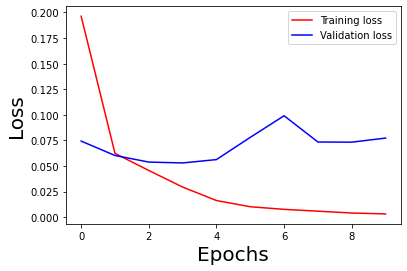

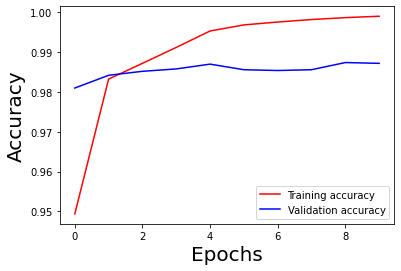

In [21]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

#plt.figure(figsize=(9,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
#plt.title('Training and validation loss', size=10)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 10})
plt.show()

#plt.figure(figsize=(9,6))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
#plt.title('Training and validation accuracy', size=10)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 10})
#plt.ylim((0.5,1))
plt.show()

Correct predictions: 4934.0
Total number of test examples: 4998
Accuracy of model1:  0.9871948779511804


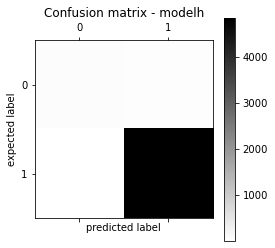

<AxesSubplot:>

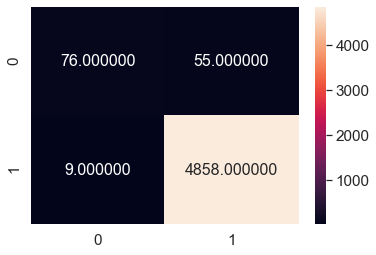

In [22]:
# Test model 1
import seaborn as sns
test_preds = modelh.predict(x_test)
test_preds = np.round(test_preds)
correct_predictions = float(sum(test_preds == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model1: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
x_pred = modelh.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest')
plt.title('Confusion matrix - modelh')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
plt.show()
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm,annot=True,annot_kws={"size": 16},fmt='1f')# font size

In [23]:
cv_report = classification_report(y_test,test_preds)
print(cv_report)

              precision    recall  f1-score   support

           0       0.89      0.58      0.70       131
           1       0.99      1.00      0.99      4867

   micro avg       0.99      0.99      0.99      4998
   macro avg       0.94      0.79      0.85      4998
weighted avg       0.99      0.99      0.99      4998
 samples avg       0.99      0.99      0.99      4998



AUC: 0.789


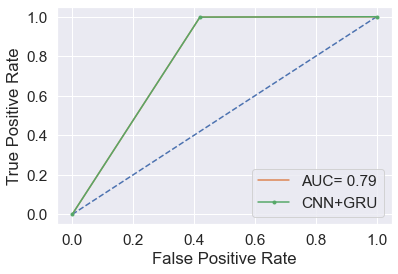

In [24]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
pos_probs = x_pred
plt.plot([0, 1], [0, 1], linestyle='--')
fpr, tpr, _ = roc_curve(y_test_s, pos_probs)

# calculate AUC
auc = roc_auc_score(y_test_s, pos_probs)
print('AUC: %.3f' % auc)

plt.plot(fpr, tpr, linestyle='-', label=('AUC= %.2f' % auc))
plt.plot(fpr, tpr, marker='.', label='CNN+GRU')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()